In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from datatools import wfip2
from datatools.remote_sensing import ESRL_wind_profiler, Vaisala_CL31

# Compare PBL height (mixing height) observations
Based on `Wasco_PBL_obs`

## read radar.z02.b0 data
Radar • ANL Wind Profiler with RASS, Goldendale • Reviewed Data

60-m vertical resolution up to 1.5 km for the 915 MHz and 60-m up to 3.5k m for the 449 MHz

45.80552, -120.84861

Averaged at interval of 60 minutes at the *start* of the bin

In [3]:
elev = 502. # [m]

In [4]:
datadir = '/Users/equon/WFIP2/Goldendale'

In [5]:
%%time
wind = wfip2.read_dir(datadir,reader=ESRL_wind_profiler,ext='winds.txt',
                      modes=1,check_na=['SPD','DIR','SNR'],na_values=999999)
wind = wind.set_index('date_time')

CPU times: user 369 ms, sys: 14 ms, total: 383 ms
Wall time: 403 ms


In [6]:
%%time
rass = wfip2.read_dir(datadir,reader=ESRL_wind_profiler,ext='temp.txt',
                      modes=1,check_na=['T','Tc','W'])
rass = rass.set_index('date_time')

CPU times: user 220 ms, sys: 10.3 ms, total: 230 ms
Wall time: 239 ms


In [7]:
wind.head()

,HT,SPD,DIR,MET_QC,RAD.0,RAD.1,RAD.2,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2,QC.0,QC.1,QC.2
date_time,,,,,,,,,,,,,,,,
2016-11-21 00:00:13,0.054,5.1,301.0,2.0,0.0,-1.3,1.6,3.0,2.0,2.0,-25.0,-26.0,-26.0,0.3,0.0,0.0
2016-11-21 00:00:13,0.111,5.1,289.0,2.0,-0.1,-1.6,1.3,3.0,1.0,1.0,-20.0,-26.0,-25.0,0.5,0.0,0.0
2016-11-21 00:00:13,0.169,3.7,298.0,2.0,0.1,-1.0,1.1,15.0,11.0,13.0,-16.0,-13.0,-20.0,0.2,0.0,0.4
2016-11-21 00:00:13,0.226,4.0,297.0,2.0,0.0,-1.1,1.2,19.0,18.0,17.0,-15.0,-13.0,-16.0,0.7,0.0,1.1
2016-11-21 00:00:13,0.283,5.0,294.0,2.0,-0.1,-1.4,1.4,20.0,12.0,12.0,-15.0,-14.0,-15.0,1.1,0.0,2.9


In [8]:
rass.head()

,HT,T,Tc,W,QC_T,QC_Tc,QC_W,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2
date_time,,,,,,,,,,,,,
2016-11-21 00:55:43,0.202,11.2,11.2,0.0,0.0,0.0,0.0,16.0,16.0,16.0,16.0,16.0,-5.0
2016-11-21 00:55:43,0.307,11.0,10.8,0.1,0.0,0.0,0.0,16.0,16.0,16.0,23.0,23.0,3.0
2016-11-21 00:55:43,0.412,10.6,10.3,0.2,0.0,0.0,0.0,16.0,16.0,16.0,9.0,9.0,-1.0
2016-11-21 00:55:43,0.517,9.5,9.2,0.1,0.0,0.0,0.0,16.0,15.0,16.0,-4.0,-4.0,-5.0
2016-11-21 00:55:43,0.622,8.7,8.4,0.2,0.0,0.0,0.0,16.0,16.0,16.0,-8.0,-8.0,-8.0


In [9]:
z = rass['HT'].unique()

## calculate virtual potential temperature
NOAA approach (from Irina Djalalova, 2019-01-31):
- corrected temperature is _not_ used (correction is only for vertical velocity and has no appreciable effect; radio frequency interference and outliers are not accounted for)
- assumes standard atmosphere (http://glossary.ametsoc.org/wiki/Standard_atmosphere)

Equations:

1. Barometric formula for an exponential atmosphere with nonzero lapse rate
$p = p_0 \left[\frac{T_0 - \Gamma(h-h_0)}{T_0}\right]^{1/(\Gamma R/g)}
= p_0 \left[\frac{T_0/\Gamma - h_{asl}}{T_0/\Gamma}\right]^{1/(\Gamma R/g)}$
2. Poisson equation - the relationship between temperature T and pressure p of an ideal gas undergoing an adiabatic process

Notes:
- lapse rate ($\Gamma$) is 6.5$^\circ$C/km, $\Gamma R/g$ = 0.19
- temperature at zero pressure altitude is 15 deg C; $T_0/\Gamma$ = 44331 m
- for one standard atmosphere, $p_0$ = 101,325 Pa; Eqn 1 can also be written
$p = 100\left(\frac{44331-h_{asl}}{11880}\right)^{1/0.19}
= 100\left(1013.25^{0.19}\frac{44331-h_{asl}}{44331}\right)^{1/0.19}
= p_0\left(\frac{44331-h_{asl}}{44331}\right)^{1/0.19}$
- $R/c_p \approx R_d/C_{pd} \approx 287./1004. = 0.286$

In [10]:
rass['P'] = 100.*((44331.514 - (rass['HT']*1000.+elev))/11880.516)**(1./0.1902632)

In [11]:
Pref = 100000. # reference pressure [Pa]
rass['VPT'] = ((rass['T']+273.16)*(Pref/rass['P'])**0.286) # [K]

In [12]:
rass_clean = rass.loc[rass['QC_T']==0]
len(rass),len(rass_clean)

(864, 604)

## check Nov 21, 2016

In [13]:
tstart,tend = pd.to_datetime('2016-11-21 17:00'), pd.to_datetime('2016-11-22 05:00')
#datetime_range = (rass.index >= tstart) & (rass.index <= tend)

### first, check potential temperature profile

In [14]:
datetime_range = (rass.index >= tstart-pd.to_timedelta(10,unit='m')) & (rass.index <= tend)
rass_nov21 = rass.loc[datetime_range].pivot(columns='HT',values='VPT')

In [15]:
rass_nov21.head()

HT,0.202,0.307,0.412,0.517,0.622,0.727,0.832,0.937,1.041,1.146,1.251,1.356,1.461,1.566,1.671,1.776,1.881,1.986
date_time,,,,,,,,,,,,,,,,,,
2016-11-21 16:55:40,287.435552,288.171305,288.705553,288.623408,288.850011,289.492679,290.138767,289.950778,290.170195,290.505609,291.053884,291.498649,291.412164,291.751840,292.092695,292.650428,293.319230,294.100349
2016-11-21 17:55:47,288.251957,288.888251,289.322313,289.448754,289.678373,290.116227,290.034460,289.950778,289.960049,289.978299,290.418765,290.436181,290.985593,291.751840,292.522464,293.189657,293.643985,NaN
2016-11-21 18:55:04,288.864260,289.195513,289.219520,289.551922,289.989009,290.220152,289.721541,290.369540,290.905708,290.927457,291.159737,291.179908,291.305522,291.430716,292.092695,292.111199,292.236711,293.122405
2016-11-21 19:55:44,288.966311,289.707617,289.939074,289.345586,289.574828,289.804453,289.825848,289.950778,289.960049,290.189223,290.312912,290.436181,290.772308,291.537757,292.200137,292.973965,293.535733,NaN
2016-11-21 20:55:01,288.966311,289.810038,290.041867,289.861427,289.574828,289.596604,289.304315,289.636707,289.960049,289.978299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
len(rass_nov21),rass_nov21.index

(13, DatetimeIndex(['2016-11-21 16:55:40', '2016-11-21 17:55:47',
                '2016-11-21 18:55:04', '2016-11-21 19:55:44',
                '2016-11-21 20:55:01', '2016-11-21 21:55:42',
                '2016-11-21 22:55:50', '2016-11-21 23:55:42',
                '2016-11-22 00:55:02', '2016-11-22 01:55:42',
                '2016-11-22 02:55:50', '2016-11-22 03:55:42',
                '2016-11-22 04:55:50'],
               dtype='datetime64[ns]', name='date_time', freq=None))

In [17]:
tt,zz = np.meshgrid(rass_nov21.index.unique(),z,indexing='ij')

Text(0.5, 1.0, '2016-11-21 to 2016-11-22')

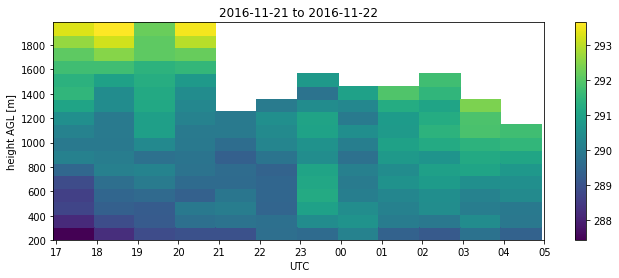

In [18]:
fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,1000*zz,rass_nov21)
fig.colorbar(pcm)
ax.set_xlabel('UTC')
ax.set_ylabel('height AGL [m]')

ax.set_xticks(pd.date_range(tstart,tend,freq='H'))#, minor=True)
ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_locator(mdates.DayLocator())
#ax.xaxis.set_minor_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-$b-%y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_title('{:s} to {:s}'.format(str(tstart.date()),str(tend.date())))

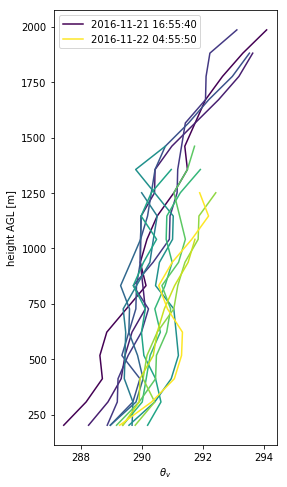

In [19]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (rass_nov21.index[-1] - rass_nov21.index[0]).total_seconds()
for ti,row in rass_nov21.iterrows():
    tfrac = (ti - rass_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'$\theta_v$')
ax.set_ylabel('height AGL [m]')
ax.legend()

### check signal-to-noise

In [20]:
datetime_range = (wind.index >= tstart) & (wind.index <= tend)
snr0_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.0')
snr1_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.1')
snr2_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.2')

In [21]:
len(snr0_nov21),snr0_nov21.index

(12, DatetimeIndex(['2016-11-21 17:00:08', '2016-11-21 18:00:11',
                '2016-11-21 19:00:01', '2016-11-21 20:00:06',
                '2016-11-21 21:00:09', '2016-11-21 22:00:11',
                '2016-11-21 23:00:02', '2016-11-22 00:00:06',
                '2016-11-22 01:00:09', '2016-11-22 02:00:12',
                '2016-11-22 03:00:02', '2016-11-22 04:00:07'],
               dtype='datetime64[ns]', name='date_time', freq=None))

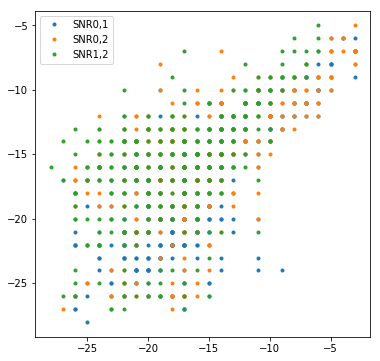

In [22]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(snr0_nov21.values.ravel(),snr1_nov21.values.ravel(),'.',label='SNR0,1')
ax.plot(snr0_nov21.values.ravel(),snr2_nov21.values.ravel(),'.',label='SNR0,2')
ax.plot(snr1_nov21.values.ravel(),snr2_nov21.values.ravel(),'.',label='SNR1,2')
ax.legend()

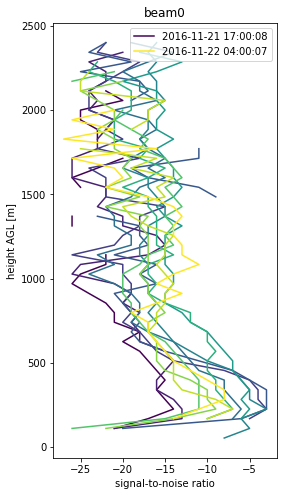

In [23]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (snr0_nov21.index[-1] - snr0_nov21.index[0]).total_seconds()
for ti,row in snr0_nov21.iterrows():
    tfrac = (ti - snr0_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'signal-to-noise ratio')
ax.set_ylabel('height AGL [m]')
ax.set_title('beam0')
ax.legend()

In [24]:
snr_nov21 = (snr0_nov21 + snr1_nov21 + snr2_nov21)/3

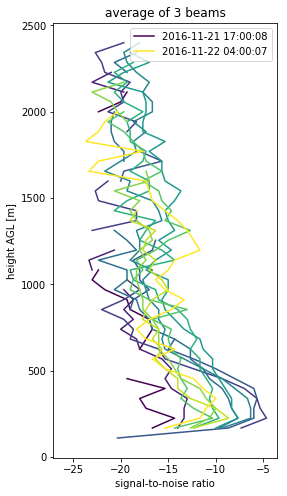

In [25]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (snr_nov21.index[-1] - snr_nov21.index[0]).total_seconds()
for ti,row in snr_nov21.iterrows():
    tfrac = (ti - snr_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'signal-to-noise ratio')
ax.set_ylabel('height AGL [m]')
ax.set_title('average of 3 beams')
ax.legend()

### 1-hr near-neutral period (SciTech 2019 study)

In [26]:
inrange = (wind.index >= '2016-11-21 22:00') & (wind.index <= '2016-11-21 23:15')
signals = ['SNR.0','SNR.1','SNR.2']
heights = 1000 * wind.loc[inrange,'HT'].unique()

Text(0.5, 1.0, 'Radar Wind Profiler')

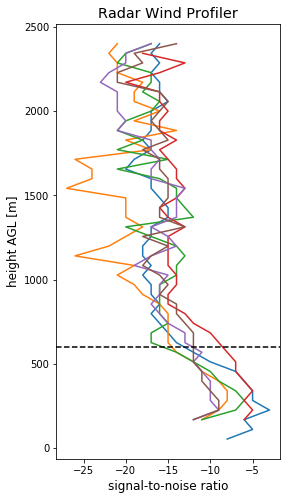

In [27]:
fig,ax = plt.subplots(figsize=(4,8))
df0 = wind.loc[inrange,signals]
for t in df0.index.unique():
    for sig in signals:
        ax.plot(df0.loc[df0.index==t,sig],heights)
ax.axhline(600,color='k',ls='--')
ax.set_xlabel(r'signal-to-noise ratio',fontsize='large')
ax.set_ylabel('height AGL [m]',fontsize='large')
ax.set_title('Radar Wind Profiler',fontsize='x-large')